In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy as spx
import matplotlib.pyplot as plt
import skimage
from skimage.io import imsave, imread
from cucim.skimage.exposure import equalize_adapthist, rescale_intensity
from cucim.skimage.filters import threshold_otsu, threshold_local, unsharp_mask, apply_hysteresis_threshold
from cucim.skimage.morphology import disk, opening, binary_dilation
from cucim.skimage.measure import label, regionprops
from cucim.skimage.color import rgb2gray, label2rgb
# from cucim.skimage.metrics import structural_similarity, mean_squared_error
# from cucim.skimage.transform import rescale
# from cupyx import scipy as spx
import pandas as pd

(3072, 3072)


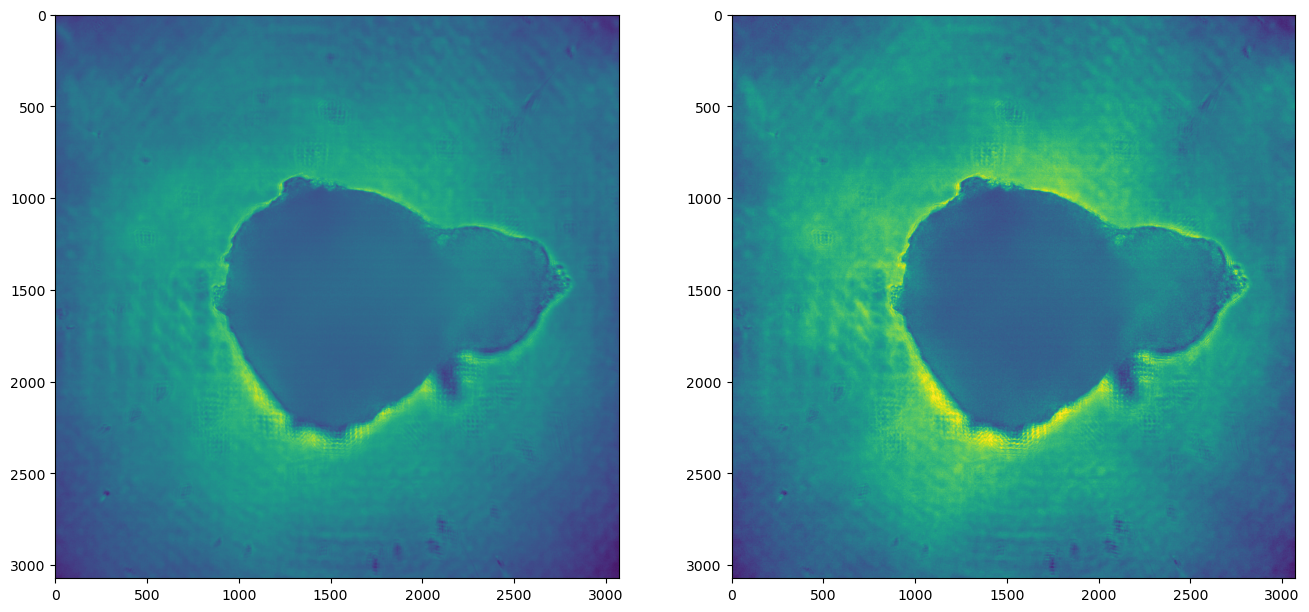

In [13]:
organoid = imread("/home/col/AC_Data/UNC_data/20230621/green-P18-day12-2023-06-21/MCAM_image_frame_9/cam1_2.png")/255
# organoid = imread("cam6_3.bmp")/255

organoid = cp.array(organoid, dtype=cp.float32)
organoid_min = cp.max(organoid, axis=2)
print(organoid_min.shape)
organoid = rgb2gray(organoid)
organoid_aeq = equalize_adapthist(organoid_min, nbins=256, clip_limit=0.004)
# organoid_aeq = spx.ndimage.median_filter(organoid_aeq, size=31)
# plt.imshow(organoid.get())
# plt.colorbar()
# fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,48))
# for i in range(3):
#     ax[i].imshow(organoid[:,:,i].get())

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,32))
ax[0].imshow(organoid.get())
ax[1].imshow(organoid_aeq.get())

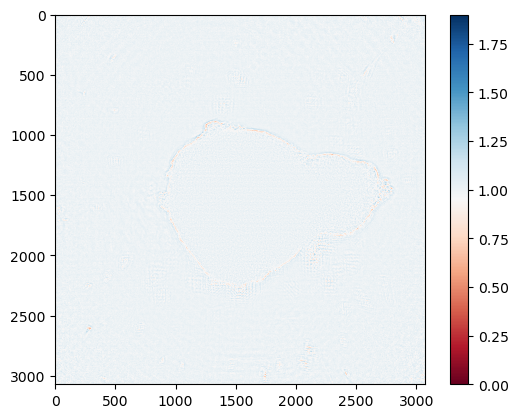

In [14]:
organoid_gb = spx.ndimage.gaussian_filter(organoid_aeq, sigma=8)
kevinsFilter = np.divide(organoid_aeq, organoid_gb)
# kevinsFilter = spx.ndimage.median_filter(kevinsFilter, size=31)
plt.imshow(kevinsFilter.get(), cmap="RdBu")
plt.colorbar()

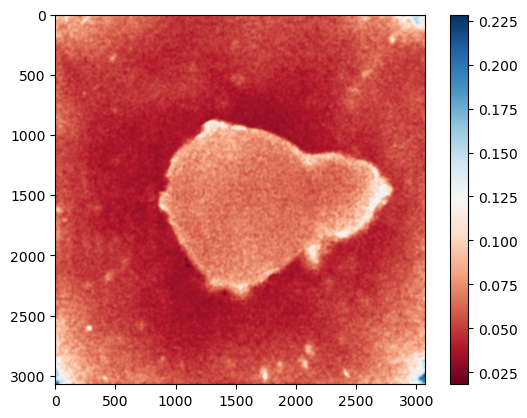

In [15]:
from cucim.skimage.filters import scharr
from cucim.skimage.feature import canny

# mask = canny(organoid_mb, sigma=51, use_quantiles=True)
edges = scharr(kevinsFilter)
edges = spx.ndimage.gaussian_filter(edges, sigma=8)
# edges = edges*mask
# edges = cp.square(edges)
plt.imshow(edges.get(), cmap="RdBu")
plt.colorbar()


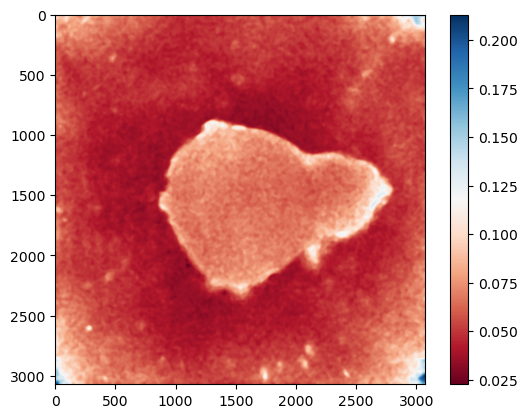

In [16]:
organoid_mb = spx.ndimage.median_filter(edges, size=25)
# p25, p75 = np.percentile(organoid_itn_rescale.get(), (45, 97))
# print(p25, p75)
# organoid_itn_rescale = rescale_intensity(organoid_itn_rescale, (p25, p75))
plt.imshow(organoid_mb.get(), cmap="RdBu")
plt.colorbar()

0.04378932993859053 0.06506172567605972


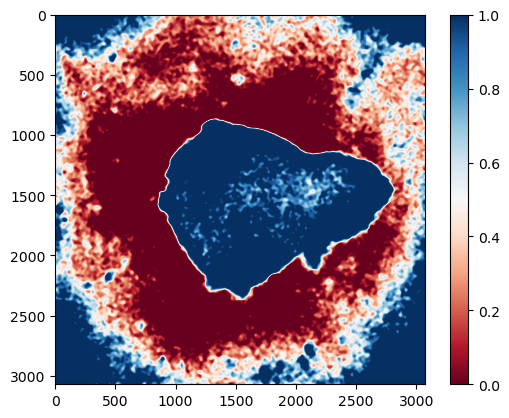

In [17]:
p25, p75 = np.percentile(organoid_mb.get(), (25, 75))
print(p25, p75)
organoid_mb = rescale_intensity(organoid_mb, (p25, p75))
plt.imshow(organoid_mb.get(), cmap="RdBu")
plt.colorbar()

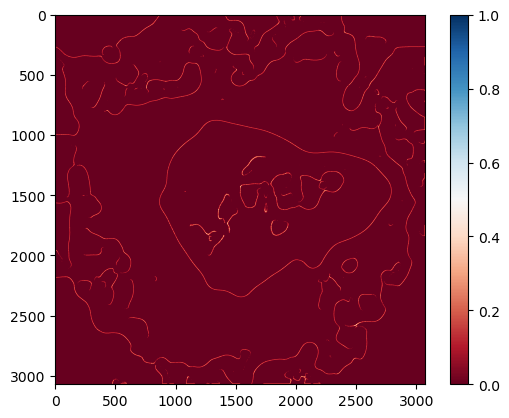

In [18]:
edges = canny(organoid_mb, sigma=55, low_threshold=0.1, high_threshold=0.2, use_quantiles=True)
# edges = scharr(organoid_mb)
# edges = spx.ndimage.gaussian_filter(edges, sigma=8)
# edges = edges*mask
# edges = cp.square(edges)
plt.imshow(edges.get(), cmap="RdBu")
plt.colorbar()

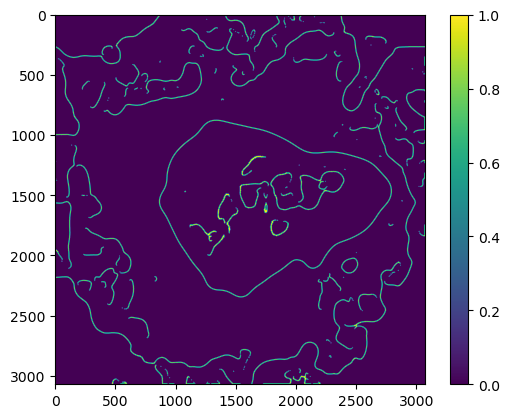

In [19]:
footprint = disk(3)
edges = binary_dilation(edges, footprint=footprint)
plt.imshow(edges.get())
plt.colorbar()

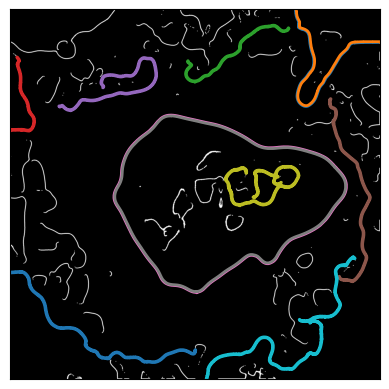

In [20]:
from skimage.measure import find_contours
cfin = edges.get()
contours = find_contours(cfin, 0.8)
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(cfin, cmap=plt.cm.gray)

for contour in contours:
    if contour.shape[0] > 2000:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

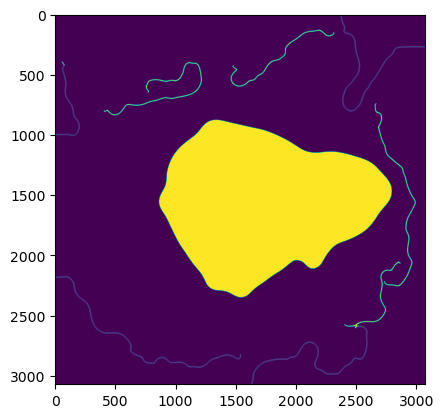

In [21]:
import scipy.ndimage as ndimage    

# Create an empty image to store the masked array
r_mask = np.zeros_like(cfin, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value

for contour in contours:
    if contour.shape[0] > 2000:
        r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

plt.imshow(r_mask)

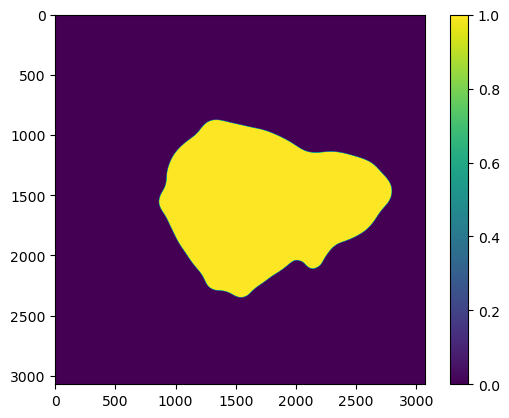

In [22]:
footprint = disk(11)
r_mask = cp.array(r_mask)
r_mask = opening(r_mask, footprint=footprint)
# organoid_th_closed = opening(organoid_th_closed, footprint=footprint)

plt.imshow(r_mask.get())
plt.colorbar()

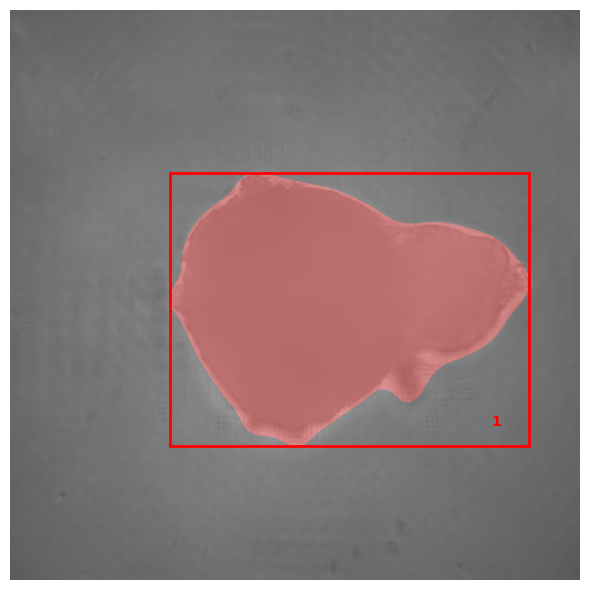

In [23]:
# organoid_th_closed = organoid_th_closed.get()
organoid_th_closed = r_mask.get()

org_label = skimage.measure.label(organoid_th_closed, connectivity=2)
image_label_overlay = skimage.color.label2rgb(org_label, image=organoid.get(), bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

import matplotlib.patches as mpatches

for region in regionprops(org_label):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/1.1
        cy = ry + rect.get_height()/1.1
        ax.annotate("{}".format(region.label), (cx, cy), color='red', weight='bold', fontsize=10, ha='center', va='center')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [24]:
def pixelcount(regionmask):
    return np.sum(regionmask)
regions = skimage.measure.regionprops_table(org_label, organoid.get(), extra_properties=(pixelcount,))
data = pd.DataFrame(regions)
data = data.sort_values(by=["pixelcount"], ascending=False)
data


label  bbox-0  bbox-1  bbox-2  bbox-3  pixelcount
0      1     878     864    2352    2796     1821867

In [8]:
# organoid_rescaled_gb = scipy.ndimage.gaussian_filter(organoid_itn_rescale, sigma=5)
# organoid_rescaled_mb = spx.ndimage.median_filter(organoid_itn_rescale, size=51)
# plt.imshow(organoid_rescaled_mb.get())
# plt.colorbar()

0.14290993213653558

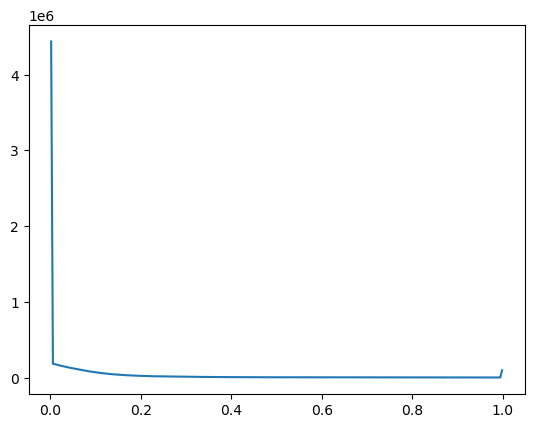

In [9]:
from cucim.skimage.exposure import histogram

a, b = histogram(organoid_itn_rescale)
plt.plot(b.get(),a.get())

p30 = np.percentile(organoid_itn_rescale.get(), 85)
p30

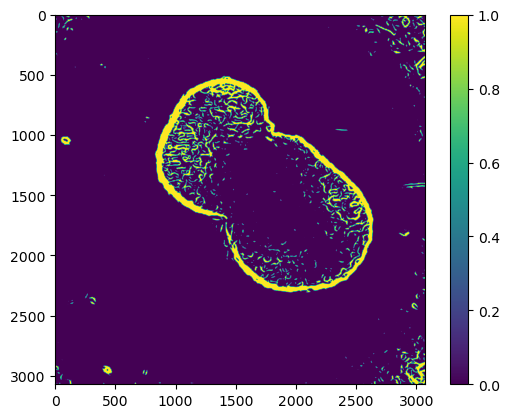

In [10]:
# organoid_adapt_th = organoid_itn_rescale > threshold_local(organoid_itn_rescale, block_size=1001, method='gaussian')
# organoid_otsu_th = organoid_mb > threshold_otsu(organoid_mb, nbins=256)
organoid_otsu_th = organoid_itn_rescale > threshold_otsu(organoid_itn_rescale, nbins=256)
# organoid_otsu_th = organoid_itn_rescale > p30
# organoid_otsu_th = edges > threshold_otsu(edges, nbins=256)

plt.imshow(organoid_otsu_th.get())
plt.colorbar()

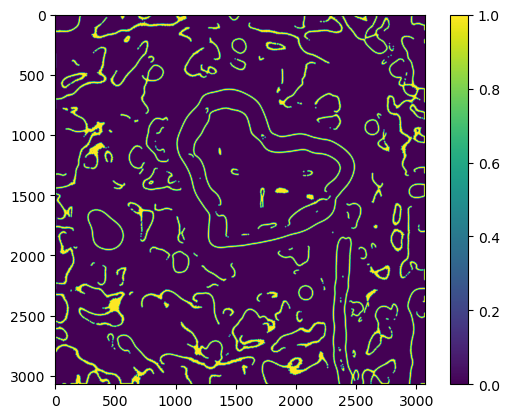

In [16]:
footprint = disk(5)
organoid_th_closed = opening(organoid_otsu_th, footprint=footprint)
# organoid_th_closed = opening(organoid_th_closed, footprint=footprint)

plt.imshow(organoid_th_closed.get())
plt.colorbar()

Random Walker


p25, p75 = np.percentile(organoid, (25, 75))
print(p25, p75)
data = skimage.exposure.rescale_intensity(organoid, (p25, p75))

markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2

# Run random walker algorithm
labels = skimage.segmentation.random_walker(data, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()